# Tutorial 04 – Preprocessing + Instance Based Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## Preprocessing

The preprocessing is crutial part of any machine learning. Having clean and high quality data is offten more beneficial than using complex state of the art machine learning model on poor data. After all, machine learning is just statistics on steroids and while you can do statitistics on random noise any conclusions will be worthless.

### Standardization and Scaling

This preprocessing step is transforming feature values so that they have a "nicer" distribution. There is no universal definition of nice distribution, but some models we will encounter later in the semester for example require features to be centered around zero and have normal distribution. This can be achieved through transformation known as standardization that we have seen in the tutorial 03. There we used [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) to transform each feature to have zero mean and unit standard deviation.

Other models (including KNN in this tutorial) require features to be of the same magnitudes. Otherwise features with high magnitudes will dominate and the model will be bias towards deciding only according to these features. `scikit-lean` provides [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) and [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html#sklearn.preprocessing.MaxAbsScaler) for scaling features to the same magnitude. This way the relative differences between example are preserved but differences between features.

For example, suppose we have a dataset with cake recipes with amount of flour in grams and number of eggs. Then difference between 400g and 415g of flour (roughly one tablespoon) would be the same difference for the model as 5 or 20 eggs. After scaling, the difference in flour content would be smaller then 0.1 but difference in eggs would around 1.

All scaler mentioned above are sensitive to outliers. So unless you remove them before scaling you might want to use more robust scaler. One such is [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler) that scale values base on quantile values.

Another more exotic variant of scaling is quantile scaling done by [QuantileTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html#sklearn.preprocessing.QuantileTransformer). Here the feature values are scaled to match a desired output distribution. By default this is uniform distribution between [0, 1]. This transformation is non-linear meaning relative differences between feature values are not preserved. On the other hand, the value rank (or ordering) is preserved. This kind of transformation is thus useful in recommendation or ranking problems.

Take a look at [transformation examples](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#) in `scikit-learn` documentation and you can also read more on their properties [here](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling).

### Missing Values

Missing values are common phenomena in real life data. A measuring sensor can malfunction, people forget to fill out few questions, or some informations may be classified or censored to protect privacy. There are, however, key distinction in mechanisms that cause missing data based on what data is actually missing.

#### Missing Completely at Random (MCAR)
In this case there is no relation between what is missing and what is the true value that would be otherwise recorded. Typical example is a faulty sensor that sometimes stops working for no apparent reason.

#### Missing at Random (MAR)
In this case there is relation between what data is missing and what data is observed but not the actual missing vales. So, for example, if men are more likely to tell you their weight than women, weight is MAR.

#### Missing Not at Random (MNAR)
In this case there is a relation between what data is missing and what are the true missing values. Let's say we have a temperature sensor that will stop working if the ambient temperature is above 35 °C. Data from this sensor is MNAR and any analysis done on them will be biased towards temperatures below 35 °C where the senor is working and recording data.

You can read more on these mechanisms in this more statistical [blog post](https://www.theanalysisfactor.com/missing-data-mechanism/).

Knowing the mechanisms of missing values is crucial if we want to make correct conclusions or train an unbiased machine learning model. While MCAR and MAR can be imputed with varying difficulty MNAR are almost impossible to impute.

#### Practical examples
Let's create an artificial missing values using different mechanisms. We will use simple dataset with data about three different species of iris flower.

In [2]:
from sklearn.datasets import load_iris

iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df["species"] = pd.Categorical(iris.target_names[iris.target])
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


To simplify things a bit, let's just add missing values to feature petal length and always make 30 % of data missing.

MCAR

In [3]:
np.random.seed(42)
na_indices = np.random.choice(len(iris_df), int(len(iris_df) * 0.3), replace=False)
iris_mcar = iris_df.copy()
iris_mcar.iloc[na_indices, 2] = np.nan

MAR, data is missing based on species but not based on value of feature

In [4]:
np.random.seed(42)
na_indices = np.random.choice(
    len(iris_df),
    int(len(iris_df) * 0.3),
    replace=False,
    p=iris_df.species.cat.codes * 2 / sum(iris_df.species.cat.codes * 2),
)
iris_mar = iris_df.copy()
iris_mar.iloc[na_indices, 2] = np.nan

MNAR, higher values of feature are more likely to be missing (4th power is just to exaggerate a bit)

In [5]:
np.random.seed(42)
na_indices = np.random.choice(
    len(iris_df),
    int(len(iris_df) * 0.3),
    replace=False,
    p=iris_df["petal length (cm)"] ** 4 / sum(iris_df["petal length (cm)"] ** 4),
)
iris_mnar = iris_df.copy()
iris_mnar.iloc[na_indices, 2] = np.nan

We can inspect the data both visually

Text(0.5, 1.0, 'MNAR')

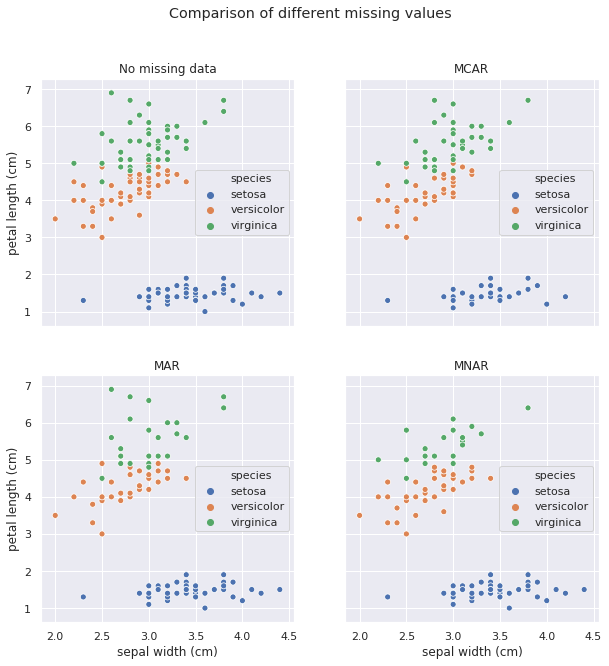

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

fig.suptitle("Comparison of different missing values")

sns.scatterplot(
    data=iris_df,
    x="sepal width (cm)",
    y="petal length (cm)",
    hue="species",
    ax=axes[0][0],
)
axes[0][0].set_title("No missing data")
sns.scatterplot(
    data=iris_mcar,
    x="sepal width (cm)",
    y="petal length (cm)",
    hue="species",
    ax=axes[0][1],
)
axes[0][1].set_title("MCAR")
sns.scatterplot(
    data=iris_mar,
    x="sepal width (cm)",
    y="petal length (cm)",
    hue="species",
    ax=axes[1][0],
)
axes[1][0].set_title("MAR")
sns.scatterplot(
    data=iris_mnar,
    x="sepal width (cm)",
    y="petal length (cm)",
    hue="species",
    ax=axes[1][1],
)
axes[1][1].set_title("MNAR")

and using statistics.

In [7]:
print("No missing data")
print(iris_df.groupby("species")["petal length (cm)"].mean())

print("MCAR")
print(iris_mcar.groupby("species")["petal length (cm)"].mean())

print("MAR")
print(iris_mar.groupby("species")["petal length (cm)"].mean())

print("MNAR")
print(iris_mnar.groupby("species")["petal length (cm)"].mean())

No missing data
species
setosa        1.462
versicolor    4.260
virginica     5.552
Name: petal length (cm), dtype: float64
MCAR
species
setosa        1.464516
versicolor    4.210811
virginica     5.545946
Name: petal length (cm), dtype: float64
MAR
species
setosa        1.462000
versicolor    4.275000
virginica     5.626087
Name: petal length (cm), dtype: float64
MNAR
species
setosa        1.462
versicolor    4.160
virginica     5.425
Name: petal length (cm), dtype: float64


Notice there is a decrease of mean petal length in case of MNAR caused by systematic missing data. Higher values were more likely to be missing.

### What to do with missing data
There are two main approaches.

1. Discard any examples and/or features with missing data.
2. Impute missing date with some plausible values.

Option 1) is a bit crude and will leave us with less data to train the model. It is, however, acceptable approach in cases where a) we have a lot of data and only few missing values or b) the feature has mostly missing values.

Option 2) is more typical and aims at filling the missing data (imputing) with values that are at least plausible. We have used [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) in tutorial 03 that is imputing values base on simple statistics (mean, median, mode) or user predefined constant. This is fine as long as the features are independent. If the features are correlated or otherwise related, `SimpleImputer` might be too simple.

Luckily, `scikit-learn` provides two more sophisticated imputers – [IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#) and [KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#). `IterativeImputer` tries to model each feature as a function of the remaining features and predicts the missing values. `KNNImputer` looks at `k` closest examples (neighbors) in the data and imputes a weighted average of the feature values in these neighbors. Note that `IterativeImputer` is still a bit experimental and needs to be explicitly enabled by importing from `sklearn.experimental` (see below).

<div class="alert alert-block alert-warning"><b>Exercise 1</b></div>

We would like to evaluate the performance of each imputer when compared to the original values we removed. Use all **three imputers** to impute missing values of the **three datasets** with missing values created above. Next, evaluate their performance by **computing RMSE** of the imputed values and actual values in the original dataset.

You can use function computing RMSE from previous tutorials or the one from `scikit-learn`. Do not forget to deal with categorical column. Expected RMSE are in the table below.

| Imputer | Dataset | RMSE |
|---------|---------|------|
|Simple   | MCAR    | 1.027|
|Iterative| MCAR    | 0.153|
|KNN      | MCAR    | 0.138|
|Simple   | MAR     | 1.044|
|Iterative| MAR     | 0.150|
|KNN      | MAR     | 0.157|
|Simple   | MNAR    | 1.242|
|Iterative| MNAR    | 0.185|
|KNN      | MNAR    | 0.217|

In [19]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

# TODO: your code goes here...
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

simple_imputer_pipeline = make_pipeline(
    make_column_transformer((SimpleImputer(strategy="mean"), ["petal length (cm)"]))
)

iterative_imputer_pipeline = make_pipeline(
    make_column_transformer((OneHotEncoder(), ["species"]), remainder="passthrough"),
    IterativeImputer()
)

knn_imputer_pipeline = make_pipeline(
    make_column_transformer((OneHotEncoder(), ["species"]), remainder="passthrough"),
    KNNImputer()
)

simple_mcar = simple_imputer_pipeline.fit_transform(iris_mcar)
iterative_mcar = iterative_imputer_pipeline.fit_transform(iris_mcar)[:, 5]
knn_mcar = knn_imputer_pipeline.fit_transform(iris_mcar)[:, 5]

simple_mar = simple_imputer_pipeline.fit_transform(iris_mar)
iterative_mar = iterative_imputer_pipeline.fit_transform(iris_mar)[:, 5]
knn_mar = knn_imputer_pipeline.fit_transform(iris_mar)[:, 5]

simple_mnar = simple_imputer_pipeline.fit_transform(iris_mnar)
iterative_mnar = iterative_imputer_pipeline.fit_transform(iris_mnar)[:, 5]
knn_mnar = knn_imputer_pipeline.fit_transform(iris_mnar)[:, 5]

y_true = iris_df["petal length (cm)"]

print("Simple Imputer: \tMCAR:\t", np.sqrt(mean_squared_error(y_true, simple_mcar)))
print("Iterative Imputer: \tMCAR:\t", np.sqrt(mean_squared_error(y_true, iterative_mcar)))
print("KNN Imputer: \t\tMCAR:\t", np.sqrt(mean_squared_error(y_true, knn_mcar)))

print("Simple Imputer: \tMAR:\t", np.sqrt(mean_squared_error(y_true, simple_mar)))
print("Iterative Imputer: \tMAR:\t", np.sqrt(mean_squared_error(y_true, iterative_mar)))
print("KNN Imputer: \t\tMAR:\t", np.sqrt(mean_squared_error(y_true, knn_mar)))

print("Simple Imputer: \tMNAR:\t", np.sqrt(mean_squared_error(y_true, simple_mnar)))
print("Iterative Imputer: \tMNAR:\t", np.sqrt(mean_squared_error(y_true, iterative_mnar)))
print("KNN Imputer: \t\tMNAR:\t", np.sqrt(mean_squared_error(y_true, knn_mnar)))

Simple Imputer: 	MCAR:	 1.0265299405379569
Iterative Imputer: 	MCAR:	 0.1527733517878075
KNN Imputer: 		MCAR:	 0.13746272221951666
Simple Imputer: 	MAR:	 1.0443203042932683
Iterative Imputer: 	MAR:	 0.14954454403573658
KNN Imputer: 		MAR:	 0.1567588381346753
Simple Imputer: 	MNAR:	 1.2420704315440807
Iterative Imputer: 	MNAR:	 0.18455433164242468
KNN Imputer: 		MNAR:	 0.21739058550605797


### Class Balancing
It may happen that classes we would like to classify are not equally represented in the training data. There are four strategies to handle imbalanced classes.
1. Up-sample the under-represented class(es).
2. Down-sample the over-represented class(es).
3. Add weights cost function to penalize model more for getting under-represented class wrong.
4. Use some sophisticated technique to create new example of under-represented classes by recombining them.
5. Reformulate the problem as an outlier detection where outliers are example of the under-represented class(es).

Since neither decision trees nor KNN is really affected by up/down-sampling we will return to class balancing in later tutorials.

### Feature engineering

This part of preprocessing cover creation of new features from existing features (feature extraction), projecting features, and selecting only subset of features that is most useful for the model (feature selection). We will take more in depth look at this part of preprocessing later in the semester.

## K Nearest Neighbors

We have KNN as a imputation model but it can be used as a standalone model for predictions. It can be used both for classification (with majority class between neighbors) and regression (weighted average of values of neighbors). KNN can be useful model in cases where there are few training examples. Especially if the training data is of high quality – correct labels without noise and training examples cover typical cases for each class.

We can demonstrate it in the next exercise. We would like to predict person's temperament type based on the answers in a questionnaire. To do this we have a dataset with only four examples, one for each temperament type. These examples represent answers of "prototypical" person for each temperament type.

<div class="alert alert-block alert-warning"><b>Exercise 2</b></div>

1. Load a [temperament dataset](https://www.fi.muni.cz/~xcechak1/IB031/datasets/temperament_prototypes.csv)
2. Train a [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) on it. Set the number of neighbors to 1.
3. Once trained, head over to [online Eysenck temperament test](http://similarminds.com/eysenck.html) and fill out the test for your self. Before submitting the test, mark your answers into a data frame. The answer are encoded as integers between 0 and 4 where 0 means `Very Inaccurate` and 4 means `Very Accurare`.
4. Predict the class for your self using the KNN model.
5. Submit the online test and compare the results.

Notes: The order of questions in the online test is randomized. Make sure to mark your answers to correct column.

In [22]:
# TODO: your code goes here...
from sklearn.neighbors import KNeighborsClassifier

prototype = pd.read_csv("temperament_prototypes.csv")
temperament_train, temperament_test = prototype.drop(columns="type"), prototype.type

classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(temperament_train, temperament_test)

X_me = pd.DataFrame(
    {
        "I like being in high energy environments.": 0.0,
        "I am quiet around others.": 4.0,
        "I have no trouble approaching people.": 4.0,
        "I am at ease around others.": 0.0,
        "I enjoy meeting new people.": 0.0,
        "I am very talkative.": 0.0,
        "I enjoy social gatherings.": 2.0,
        "I am outgoing.": 0.0,
        "I know how to get people to have fun.": 0.0,
        "I am very energetic.": 0.0,
        "I make friends easily.": 0.0,
        "I enjoy being part of a group.": 0.0,
        "I fear for the worst.": 0.0,
        "I am very tense.": 0.0,
        "I sometimes feel extremely sad for no reason.": 0.0,
        "I frequently feel guilty.": 0.0,
        "I suffer from anxiety.": 0.0,
        "I tend to brood on past mistakes.": 0.0,
        "I frequently feel frustrated.": 0.0,
        "I am hypersensitive.": 0.0,
        "I often feel lonely.": 0.0,
        "I am very moody.": 0.0,
        "I tend to be nervous.": 0.0,
        "I frequently worry.": 0.0,
        "Being in debt would not worry me.": 4.0,
        "I behave properly.": 0.0,
        "I respect authority.": 0.0,
        "I try not to be rude to people.": 0.0,
        "I prefer to go my own way than live by the rules.": 0.0,
        "I would like other people to be afraid of me.": 0.0,
        "I would rather play by the rules.": 0.0,
        "I think people are overly cautious.": 2.0,
        "I tend to be more comfortable with the known than the unknown.": 0.0,
        "I can be egocentric.": 0.0,
        "I can be unsympathetic.": 0.0,
        "I like to be intimidating.": 0.0,
    },
    index=[0],
)

# TODO: predics your temperament type...
classifier.predict(X_me)

NameError: name 'temperament' is not defined

<div class="alert alert-block alert-danger"><b>Exercise 3</b></div>

Let's use KNN to predict continuous variable. We will try to predict how much miles per gallon (mpg) can a car make based on its characteristics. The code for loading dataset is already written. Your job is to do the preprocessing, fitting the [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) model and then evaluating it using RMSE on test data.

You can get to RMSE of $2.135$ if you play a bit.

In [ ]:
from sklearn.model_selection import train_test_split

mpg = sns.load_dataset("mpg")
# TODO: convert categorical features to dtype Categorical...
X, y = mpg.drop(columns=["mpg"]), mpg.mpg

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# TODO: make a pipeline, fit it, and evaluat it...